In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from matplotlib import rcParams
from statsmodels.tsa import tsatools
from dmba import regressionSummary
from matplotlib.patches import Ellipse
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import date2num
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
# import pytabular as pytab
from statsmodels.graphics import tsaplots
from statsmodels.tsa.holtwinters import ExponentialSmoothing

no display found. Using non-interactive Agg backend


In [2]:
daily_peak_df=pd.read_excel('Data/niti/Daily_Peak_Demand7.xlsx',skipfooter=4)

daily_peak_df['Date']=pd.to_datetime(daily_peak_df['Date'],format='%d-%m-%Y')
daily_peak_ts=pd.Series(daily_peak_df['Peak Demand Met'].values,index=daily_peak_df['Date'],name='Daily_Peak')
daily_peak_ts.index=pd.DatetimeIndex(daily_peak_ts.index,freq='d')
daily_peak_df.dropna(inplace=True)
daily_peak_ts.dropna(inplace=True)

<bound method Axes.set of <Axes: xlabel='Date'>>

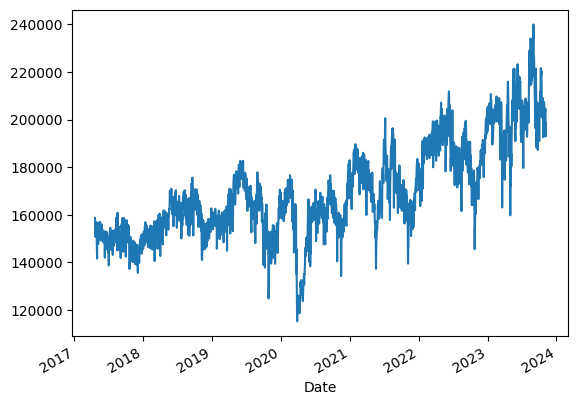

In [3]:
#check for stationarity

